# Analyze MuMMI workflow expansion

## Global Configurations

In [1]:
notebook_name = "mummi-workflow"

In [2]:
parquet_folder="/p/gpfs1/iopp/temp/mummi_c4_test_10192021/recorder_logs/recorder-20220124/_parquet"

In [3]:
num_nodes = 32

## System Imports

In [4]:
import socket
import os
import time
from time import sleep

## Create Dask Cluster for analysis

### Dask Job Queue Imports

In [5]:
import dask_jobqueue
from dask_jobqueue import LSFCluster

/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


### Dask Worker configuration
When we use dask for analysis, we need to consider the type of analysis. In this case we plan to utilize dask dataframes for analysis that is typically memory intensive. Therefore, we allocate the whole memory per node and use only 4 worker processes per node. More worker processes reduce memory available per worker resulting in frequent memory swap from filesystem.

In [6]:
node_memory = 256 # node memory in GB
n_workers_per_node = 4 # number of worker processes per node
worker_time = "02:00" # job time per node for worker
worker_queue = "pdebug" # queue to be used per worker
n_workers = 8 # number of workers to be used for analysis

Other configurations we can compute

In [7]:
host = socket.gethostname()
dashboard_address = '{}:8787'.format(socket.gethostname())
memory = '{}GB'.format(node_memory/n_workers_per_node)
job_extra = ['-nnodes 1', 
             '-G asccasc', 
             '-q {}'.format(worker_queue), 
             '-W {}'.format(worker_time), 
             '-o {}.log'.format(notebook_name), 
             '-e {}.log'.format(notebook_name)]

### Create Dask Cluster 

In [8]:
cluster = LSFCluster(cores = n_workers_per_node,processes=n_workers_per_node, memory='{}GB'.format(node_memory), 
                     header_skip=['-n ','-R','-M', '-P', '-W 00:30'], 
                     job_extra = job_extra, 
                     use_stdin=True, host = host,dashboard_address = dashboard_address)
if cluster:
    print("Created Cluster with job script\n {}".format(cluster.job_script()))

{'cls': <class 'distributed.scheduler.Scheduler'>, 'options': {'protocol': 'tcp://', 'interface': None, 'host': 'lassen709', 'dashboard_address': 'lassen709:8787', 'security': None}}
Created Cluster with job script
 #!/usr/bin/env bash

#BSUB -J dask-worker
#BSUB -nnodes 1
#BSUB -G asccasc
#BSUB -q pdebug
#BSUB -W 02:00
#BSUB -o mummi-workflow.log
#BSUB -e mummi-workflow.log
JOB_ID=${LSB_JOBID%.*}

/usr/workspace/iopp/.conda/envs/jupyter/bin/python -m distributed.cli.dask_worker tcp://192.168.66.201:34373 --nthreads 1 --nprocs 4 --memory-limit 59.60GiB --name name --nanny --death-timeout 60



### Dask Analysis Imports

In [9]:
import dask.dataframe as dd
from dask.distributed import wait, progress
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

### Create Dask Client

In [10]:
#from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
client = Client(cluster)

In [11]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.LSFCluster
Dashboard: http://192.168.66.201:8787/status,
Dashboard: http://192.168.66.201:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.66.201:34373,Workers: 0
Dashboard: http://192.168.66.201:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Spawn cluster nodes

In [12]:
cluster.scale(n_workers)

In [13]:
val = len(client.scheduler_info()["workers"])
while ((client.status == "running") and ( val < n_workers_per_node)):
    print("Waiting for workers completed {} of {}".format(val, n_workers), end="\r")
    sleep(1.0)
    val = len(client.scheduler_info()["workers"])
print("\n{} workers started".format(len(client.scheduler_info()["workers"])))

Waiting for workers completed 3 of 8
7 workers started


## Analysis Utility Functions

### Progress Bars

In [14]:
pbar = ProgressBar()
pbar.register()

### Timer functions

In [15]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

### Threading process 

In [16]:
def thread_print(string):
    print(f'{string}\n', end='')
def thread_process( num_ranks, func, start=0, list_range=[], workers=40):
    with ThreadPoolExecutor(max_workers = workers) as executor:
        if len(list_range) == 0:
            list_range = range(start, num_ranks) 
        future_gen = {executor.submit(func, rank): rank for rank in list_range}
        for future in concurrent.futures.as_completed(future_gen):
            rank = future_gen[future]
            try:
                data = future.result()
            except Exception as exc:
                thread_print('%r generated an exception: %s' % (rank, exc))
            else:
                thread_print('%r data computed' % (rank))

### Application Logs in Parquet format

## Initial Boostrapping

### Read Application logs into dask dataframe

In [17]:
ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")

In [18]:
print("Dask dataframe is split into {} partitions".format(ddf.npartitions))

Dask dataframe is split into 140 partitions


In [19]:
print("Columns present in dataset")
print(ddf.columns)

Columns present in dataset
Index(['index', 'proc', 'rank', 'thread_id', 'cat', 'tstart', 'tend',
       'func_id', 'level', 'hostname', 'arg_count', 'app', 'args_1', 'args_2',
       'args_3', 'args_4', 'args_5', 'args_6', 'args_7', 'args_8', 'args_9',
       'args_10'],
      dtype='object')


In [20]:
ddf.dtypes

index          int64
proc           int64
rank           int32
thread_id      int32
cat            int32
tstart       float32
tend         float32
func_id       object
level          int32
hostname      object
arg_count      int32
app           object
args_1        object
args_2        object
args_3        object
args_4        object
args_5        object
args_6        object
args_7        object
args_8        object
args_9        object
args_10       object
dtype: object

In [21]:
ddf.head()

,index,proc,rank,thread_id,cat,tstart,tend,func_id,level,hostname,...,args_1,args_2,args_3,args_4,args_5,args_6,args_7,args_8,args_9,args_10
0,1,26357,0,1154736,2,0.089153,0.089153,MPI_Comm_rank,0,lassen123,...,MPI_COMM_WORLD,0,,,,,,,,
1,2,26357,0,1154736,2,0.089168,0.089168,MPI_Comm_size,0,lassen123,...,MPI_COMM_WORLD,32,,,,,,,,
2,3,26357,0,1154736,0,3.760679,3.760684,readlink,0,lassen123,...,/usr/tce/packages/test_sierra_node/bin/unwrapp...,%p,4095,,,,,,,
3,4,26357,0,1154736,0,3.761142,3.761150,open,0,lassen123,...,/dev/nvidiactl,2,,,,,,,,
4,5,26357,0,1154736,0,3.761486,3.761492,close,0,lassen123,...,/dev/nvidiactl,,,,,,,,,


#### Only keep level zero from MPI and FTRACE but keep all levels for I/O

In [22]:
ddf = ddf[(ddf['level'] == 0) | ddf['cat'].isin([0,1,3])]
#ddf = ddf.persist()

### Split dataframe into I/O, MPI, and trace

In [23]:
io_ddf = ddf[ddf['cat'].isin([0,1,3])]
exclude_dirs = [".pyc", "/usr","/g/g92/haridev/.nccl.conf"]
for directory in exclude_dirs:
    io_ddf = io_ddf[~io_ddf['args_1'].str.contains(directory)]
#io_ddf[rank] = io_ddf[rank].persist()
mpi_ddf = ddf[ddf['cat'] == 2]
#mpi_ddf[rank] = mpi_ddf[rank].persist()
trace_ddf = ddf[ddf['cat'] == 4]

In [24]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Preload the I/O dataframe for faster analysis

In [25]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Check I/O interfaces used by application

In [26]:
interfaces = io_ddf['func_id'].unique().compute()
print(interfaces)

0         open
1        close
2      opendir
3     closedir
4       unlink
5       getcwd
6      fopen64
7       fseeko
8      __xstat
9       ftello
10      fclose
11       fread
12       mkdir
13      fwrite
14     symlink
Name: func_id, dtype: object


Only POSIX interface is used in this application

### Set duration of I/O events

In [27]:
io_ddf['duration'] = io_ddf['tend'] - io_ddf['tstart']

In [28]:
negetive_duration = io_ddf[io_ddf['duration'] < 0]['duration'].count().compute()
print("Application Profiler has stored {} negetive values".format(negetive_duration))

Application Profiler has stored 0 negetive values


### Create conditions for filtering
Even though this application doesnt have MPI or STDIO we have all the conditions here. This is to make sure we cover other apps as well.

In [29]:
open_condition = io_ddf['func_id'].str.contains("open")
mpi_condition = io_ddf['func_id'].str.contains("MPI")
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf['func_id'].isin(["fread"])
close_condition = io_ddf['func_id'].str.contains('close')
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf['func_id'].isin(["fwrite"])
readdir_condition = io_ddf['func_id'].isin(["readdir"])

### Extract Filename from each row.
This simplifies analysis later on as we can filter recorder per rank and per file to understand access pattern information.

In [30]:
io_ddf['filename'] = ""
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & ~mpi_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & mpi_condition, io_ddf['args_2'])
io_ddf['filename'] = io_ddf['filename'].mask(close_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(read_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fread_condition, io_ddf['args_4'])
io_ddf['filename'] = io_ddf['filename'].mask(write_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fwrite_condition, io_ddf['args_4'])

Some filename has redundent forward slashes

In [31]:
io_ddf['filename'] = io_ddf['filename'].str.replace('//','/')

### Filter recorder which have read and write operations and which have metadata.
We assume that there is only two types of operation in I/O read/write and metadata.

In [32]:
io_ddf_read_write = io_ddf[read_condition | write_condition | fread_condition | fwrite_condition].compute()
io_ddf_metadata = io_ddf[~(read_condition | write_condition | fread_condition | fwrite_condition)].compute()

### Build size and count to understand I/O on the io_ddf_read_write dataframe

In [33]:
open_condition = io_ddf_read_write['func_id'].str.contains("open")
mpi_condition = io_ddf_read_write['func_id'].str.contains("MPI")
read_condition = io_ddf_read_write['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf_read_write['func_id'].isin(["fread"])
close_condition = io_ddf_read_write['func_id'].str.contains('close')
write_condition = io_ddf_read_write['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf_read_write['func_id'].isin(["fwrite"])
readdir_condition = io_ddf_read_write['func_id'].isin(["readdir"])

In [34]:
io_ddf_read_write['size'] = 0
io_ddf_read_write['count'] = 1
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(read_condition , io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fread_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fread_condition, io_ddf_read_write['args_2'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(write_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fwrite_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fwrite_condition, io_ddf_read_write['args_2'])

#### Corner cases

In [35]:
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(readdir_condition , "0")
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(readdir_condition , "1")

#### Set Datatypes
This is needed as by default args are string from which they are set.

In [36]:
io_ddf_read_write = io_ddf_read_write.astype({'size': 'int32','count': 'int32'})

#### Compute Final Size
After this point we do not use count field.

In [37]:
io_ddf_read_write['size'] = io_ddf_read_write['size'] * io_ddf_read_write['count']

### Calculate Bandwidth in MB/s for I/O operations.
Durations might be incorrect or equal to zero due to profilers resolution issues. Therefore, we do bandwidth calculations for only correct durations.

In [38]:
correct_dur = ((io_ddf_read_write['tend'] - io_ddf_read_write['tstart']) > 0)
io_ddf_read_write['bandwidth'] = 0
io_ddf_read_write['bandwidth'] = io_ddf_read_write['bandwidth'].mask(correct_dur, io_ddf_read_write['size']*1.0/(io_ddf_read_write['tend'] - io_ddf_read_write['tstart'])/1024.0/1024.0)

### Calculate all relevent filenames in the application
The profiler might see jsrun files and other irrelevant internal files which we filter here.

In [ ]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/tmp/mummi')]['filename'].unique().compute()

In [ ]:
print("The application accesses {} files across all ranks".format(len(all_filenames)))

In [41]:
io_ddf_read_write.head()

,index,proc,rank,thread_id,cat,tstart,tend,func_id,level,hostname,...,args_6,args_7,args_8,args_9,args_10,duration,filename,size,count,bandwidth
25731,25732,68209,0,-135550816,0,51732.671875,51732.675781,fread,0,lassen123,...,,,,,,0.003906,/tmp/mummi/cg/mu12-1ras0raf-instance6_00000000...,23782959,23782959,5806.386475
259234,259235,68209,0,-135550816,0,51790.296875,51790.296875,fwrite,0,lassen123,...,,,,,,0.000000,/tmp/mummi/cg/mu12-1ras0raf-instance6_00000000...,3256339,3256339,0.000000
394317,394318,68209,0,-135550816,0,51833.453125,51833.457031,fwrite,0,lassen123,...,,,,,,0.003906,/tmp/mummi/cg/mu12-1ras0raf-instance6_00000000...,3256340,3256340,795.004883
529400,529401,68209,0,-135550816,0,51876.574219,51876.574219,fwrite,0,lassen123,...,,,,,,0.000000,/tmp/mummi/cg/mu12-1ras0raf-instance6_00000000...,3256340,3256340,0.000000
664483,664484,68209,0,-135550816,0,51919.804688,51919.808594,fwrite,0,lassen123,...,,,,,,0.003906,/tmp/mummi/cg/mu12-1ras0raf-instance6_00000000...,3256341,3256341,795.005127


### Distribution of Transfer Size and Bandwidth in the application
The transfer size is given by the size column in bytes and the bandwidth is shown in MB/s

In [42]:
io_ddf_read_write[['size', 'bandwidth']].describe()

,size,bandwidth
count,1.488000e+03,1488.000000
mean,5.892485e+06,1642.631068
std,7.714579e+06,1773.376580
min,1.974861e+06,0.000000
25%,3.269877e+06,0.000000
50%,3.280389e+06,964.639160
75%,3.291741e+06,3205.402344
max,2.953393e+07,7186.535156


### Preload the I/O dataframe for faster analysis

In [43]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Operations Per Application

In [44]:
io_ddf.groupby(['app','func_id'])['func_id'].count().compute()

app                         func_id 
unwrapped_test_sierra_node  close       12320
                            closedir       32
                            open        12736
                            opendir        32
                            unlink         32
ddcMD_GPU                   __xstat       108
                            close        6048
                            closedir      108
                            fclose       1596
                            fopen64      1596
                            fread         108
                            fseeko        216
                            ftello        324
                            fwrite       1380
                            getcwd        216
                            mkdir        1200
                            open         7452
                            opendir       108
                            symlink        60
                            unlink        168
Name: func_id, dtype: int64

In [45]:
io_ddf_read_write.groupby(['app','func_id'])['size'].sum() /1024.0/1024.0

app        func_id
ddcMD_GPU  fread      2708.221490
           fwrite     5653.611324
Name: size, dtype: float64

In [46]:
io_ddf_read_write.groupby(['app'])['proc'].nunique() 

app
ddcMD_GPU    108
Name: proc, dtype: int64

## Application Analysis

In [47]:
rank_index_series = io_ddf_read_write.groupby(['hostname','app','proc','rank', 'thread_id'])['thread_id'].nunique().cumsum()
#io_ddf_read_write['rank_index'] = 0
#for index,item in rank_index_series.iteritems():
#    condition = (io_ddf_read_write['hostname'] == index[0]) & (io_ddf_read_write['app'] == index[1]) & (io_ddf_read_write['proc'] == index[2]) & (io_ddf_read_write['rank'] == index[3]) & (io_ddf_read_write['thread_id'] == index[4])
#    io_ddf_read_write['rank_index'] = io_ddf_read_write['rank_index'].mask(condition , item - 1)

### Num Ranks

In [48]:
num_ranks = rank_index_series.nunique()
print("Number of ranks in application {}".format(num_ranks))

Number of ranks in application 108


### Total I/O amount

In [49]:
total_io = io_ddf_read_write.groupby('func_id')['size'].sum()/1024.0/1024.0/1024.0
print("Total I/O in application {} GB".format(total_io.sum()))
print("Total I/O per operation in application {} GB".format(total_io))

Total I/O in application 8.165852357633412 GB
Total I/O per operation in application func_id
fread     2.644748
fwrite    5.521105
Name: size, dtype: float64 GB


### I/O per rank

In [50]:
io_ddf_read_write.groupby(['rank', 'func_id'])['size'].sum()

rank  func_id
0     fread      2.839776e+09
      fwrite     5.928241e+09
Name: size, dtype: float64

**rank 0 performs 100x more I/O than others. Also every other process reads data where as only rank 0 writes it.**

In [ ]:
io_per_rank_gb = io_ddf_read_write.groupby(['app'])['size'].sum()/1024.0/1024.0/1024.0
io_per_rank_gb.plot(kind='bar',figsize=(12,4))

### Operations Per Rank

<AxesSubplot:xlabel='app'>

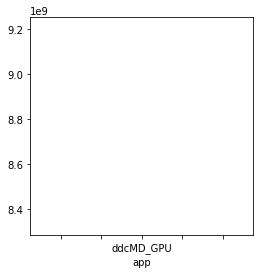

In [52]:
io_per_rank_gb = io_ddf_read_write.groupby(['app'])['count'].sum()
io_per_rank_gb.plot(kind='bar',figsize=(4,4))

**Also rank 0 performs 2000x more operations than other ranks.**

### Average I/O Time per process

In [53]:
time_per_rank = io_ddf.groupby('app')['duration'].sum().compute()

In [54]:
print("time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

time per process: Average 1.3249095678329468 sec, Max 2.52178955078125 sec, and Min 0.12802958488464355 sec


IndexError: index 0 is out of bounds for axis 0 with size 0

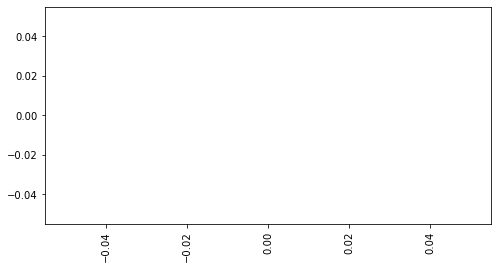

In [128]:
time_per_rank.plot(kind='bar',figsize=(8,4))

Most time is spent by rank 0.

### Compute Time

#### Convert trace dataframe into memory.

In [56]:
trace_ddf_local = trace_ddf

#### Calculate duration for trace values

In [57]:
trace_ddf_local['duration'] = trace_ddf_local['tend'] - trace_ddf_local['tstart']

In [58]:
trace_ddf_local['duration'].describe().compute()

ValueError: No non-trivial arrays found

In [59]:
negetive_durations = trace_ddf_local[trace_ddf_local['duration'] < 0]['duration'].count().compute()
print("Profiler stored {} negetive rows".format(negetive_durations))

Profiler stored 0 negetive rows


In [60]:
time_per_rank = trace_ddf_local.groupby('app')['duration'].sum().compute()

In [61]:
print("Time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

Time per process: Average nan sec, Max nan sec, and Min nan sec


In [ ]:
time_per_rank.plot(kind='bar',figsize=(4,4))

**No compute trace available**

## Job Time

In [63]:
job_time = ddf['tend'].max().compute()

In [64]:
print("Job Time in Application {} sec".format(job_time))

Job Time in Application 53873.56640625 sec


The application run for a long time includes initialization.

## Job Intensity

In [65]:
total_compute = trace_ddf_local['duration'].sum().compute()
total_io = io_ddf['duration'].sum().compute()
print("I/O Time: {} sec Compute Time: {} sec".format(total_io, total_compute))

I/O Time: 2.6498191356658936 sec Compute Time: 0.0 sec


In [66]:
io_intensity=total_io/(total_io + total_compute)
comp_intensity=total_compute/(total_io + total_compute)

In [67]:
print("I/O intensity: {}, Compute intensity: {}".format(io_intensity, comp_intensity))

I/O intensity: 1.0, Compute intensity: 0.0


**Application is not compute intensive as only 4 second of the overall time (i.e. 668 sec) is spent on I/O**

### I/O Transfer Size Distribution

[0, 0, 0, 1320, 168]


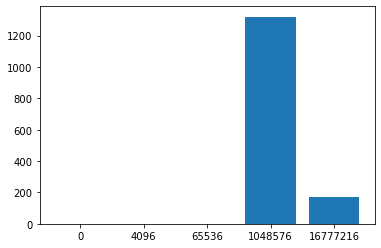

In [68]:
file_df_temp = io_ddf_read_write
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
size_ranges_str = []
for range_val in size_ranges:
    size_ranges_str.append(str(range_val))
max_range = len(size_ranges)
request_size = [0]*len(size_ranges)
for i, val in enumerate(size_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_size[i] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                       (file_df_temp['size'].lt(size_ranges[i+1]))]['size'].count()
    else:
        request_size[i] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['size'].count()

print(request_size)
plt.bar(size_ranges_str, request_size)
#file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
#plt.hist(file_sizes, bins=100)
plt.show()

**Application performs a lot of small I/O <=4 KB and reads 16MB**

### Distribution of request sizes per rank
We need this as we see most I/O occurs by rank 0

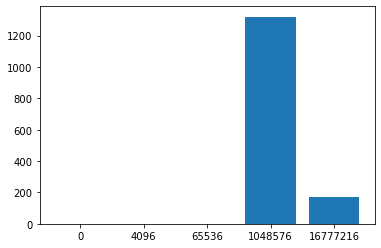

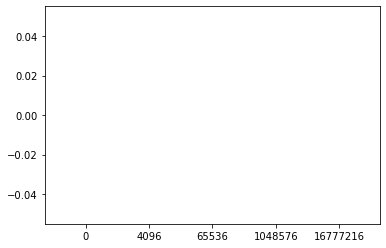

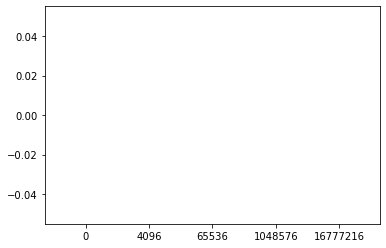

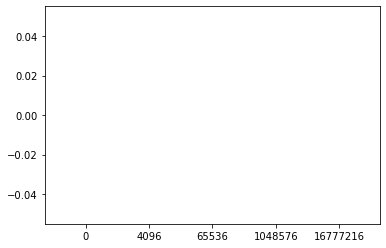

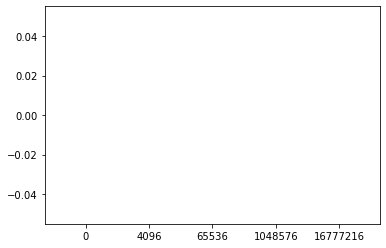

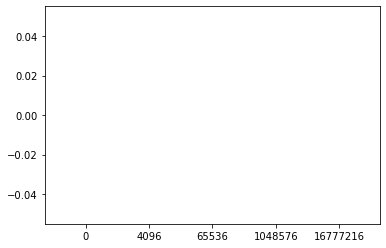

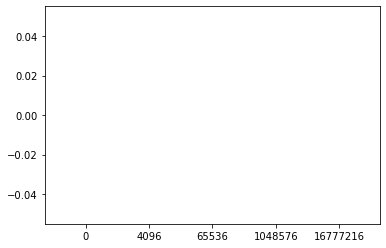

In [69]:
selected_ranks = [0,1,2,3,4,5,6]
for rank in selected_ranks:
    file_df_temp = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
    size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
    size_ranges_str = []
    for range_val in size_ranges:
        size_ranges_str.append(str(range_val))
    max_range = len(size_ranges)
    request_size = [0]*len(size_ranges)
    for i, val in enumerate(size_ranges):
        #print(i, max_range)
        if i < max_range - 1:
            request_size[i] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['size'].count()
        else:
            request_size[i] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['size'].count()

    #print(request_size)
    plt.bar(size_ranges_str, request_size)
    #file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
    #plt.hist(file_sizes, bins=100)
    plt.show()

**The application uses a transfer size of 4K (used by rank 0) and 16MB (used by other ranks)**

### Distribution of Bandwidth achived by application

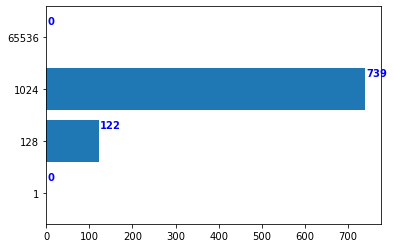

In [70]:
bw_ranges = [1, 128, 1024, 1024*64]
bw_ranges_str = []
for range_val in bw_ranges:
    bw_ranges_str.append(str(range_val))
max_range = len(bw_ranges)
request_bw = [0]*len(bw_ranges)
file_df_temp = io_ddf_read_write
for i, val in enumerate(bw_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'].ge(val)) & 
                                       (file_df_temp['bandwidth'].lt(bw_ranges[i+1]))]['size'].count()
    else:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'] >=bw_ranges[i])]['size'].count()
fig, ax = plt.subplots()
ax.barh(bw_ranges_str, request_bw)
for i, v in enumerate(request_bw):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
plt.show()

In [71]:
request_bw

[0, 122, 739, 0]

In [72]:
percentage_bw = np.array(request_bw)*100/np.sum(request_bw)
percentage_bw

array([ 0.        , 14.16957027, 85.83042973,  0.        ])

- 40% of the overall I/O got a bandwidth of 128 MB/s per process.
- 35% achieve a low bandwidth of 64GB/s

nan nan


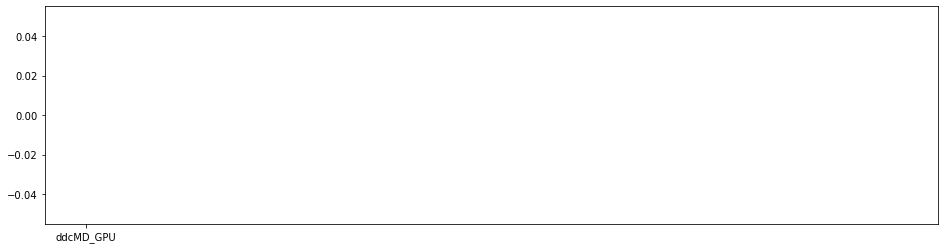

nan nan


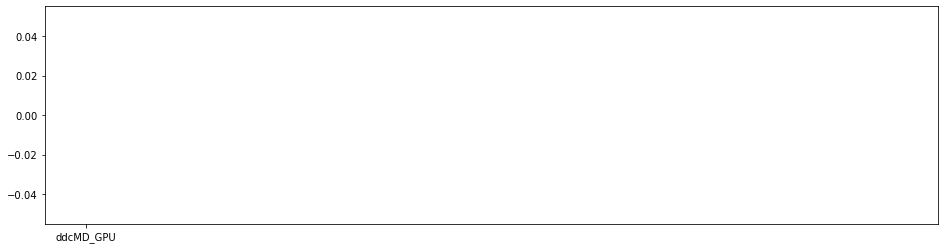

nan nan


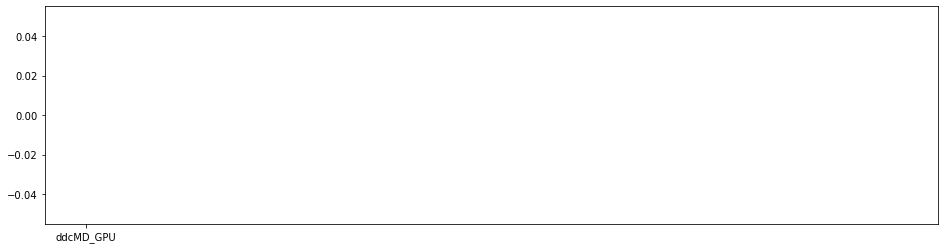

1255.7751901002048 1255.7751901002048


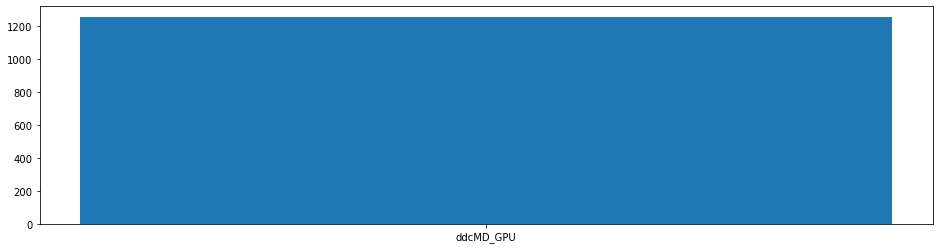

4682.21296219806 4682.21296219806


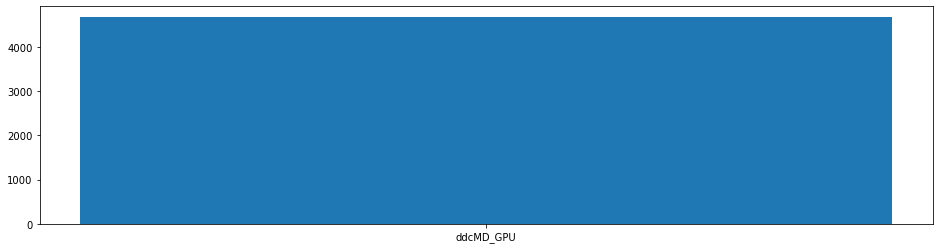

No handles with labels found to put in legend.


In [73]:
app_str = io_ddf_read_write['app'].unique()
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
request_size = [[]]*len(size_ranges)
for i, val in enumerate(size_ranges):
    request_size[i] = [0]*len(app_str)
    for j,app in enumerate(app_str):
        
        file_df_temp = io_ddf_read_write[io_ddf_read_write['app'] == app]
        max_range = len(size_ranges)
        if i < max_range - 1:
            request_size[i][j] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['bandwidth'].mean()
        else:
            request_size[i][j] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['bandwidth'].mean()
#fig, ax = plt.subplots(figsize=(16,4))
#width = 0.35
#plt.figure()
for i, val in enumerate(size_ranges):
    plt.figure(figsize=(16,4))
    print(request_size[i][0],np.median(request_size[i]))
    rects1 = plt.bar(app_str, request_size[i], 0.35, label=str(i))
    plt.show()
ax.legend()

fig.tight_layout()

plt.show()

### Number of files read/written

In [74]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()
print("The application accesses {} files".format(len(all_filenames)))
#print(all_filenames[:8],all_filenames[-8:])

The application accesses 0 files


### I/O Operations by Application

In [75]:
io_ddf.groupby('func_id')['func_id'].count().compute()

func_id
close       18368
closedir      140
open        20188
opendir       140
unlink        200
__xstat       108
fclose       1596
fopen64      1596
fread         108
fseeko        216
ftello        324
fwrite       1380
getcwd        216
mkdir        1200
symlink        60
Name: func_id, dtype: int64

**As there are 1280 ranks in total, Most I/O is performed by rank 0 rest of them do less I/O**

### IO Operations per rank

In [76]:
io_ddf.groupby(['rank','func_id'])['func_id'].count().compute()[:32]

rank  func_id 
0     close       6433
      closedir     109
      open        7850
      opendir      109
      unlink       169
      __xstat      108
      fclose      1596
      fopen64     1596
      fread        108
      fseeko       216
      ftello       324
      fwrite      1380
      getcwd       216
      mkdir       1200
      symlink       60
1     close        385
      closedir       1
      open         398
      opendir        1
      unlink         1
2     close        385
      closedir       1
      open         398
      opendir        1
      unlink         1
3     close        385
      closedir       1
      open         398
      opendir        1
      unlink         1
4     close        385
      closedir       1
Name: func_id, dtype: int64

In [77]:
io_ddf.groupby(['rank','func_id'])['func_id'].count().compute()[128:160]

rank  func_id 
23    opendir       1
      unlink        1
24    close       385
      closedir      1
      open        398
      opendir       1
      unlink        1
25    close       385
      closedir      1
      open        398
      opendir       1
      unlink        1
26    close       385
      closedir      1
      open        398
      opendir       1
      unlink        1
27    close       385
      closedir      1
      open        398
      opendir       1
      unlink        1
28    close       385
      closedir      1
      open        398
      opendir       1
      unlink        1
29    close       385
      closedir      1
      open        398
      opendir       1
      unlink        1
Name: func_id, dtype: int64

**These confirm our hypothesis that most I/O is performed by rank 0 rest of them do less I/O**

### Bandwidth per request distribution
We calculate the achived bandwidth per request size.

nan


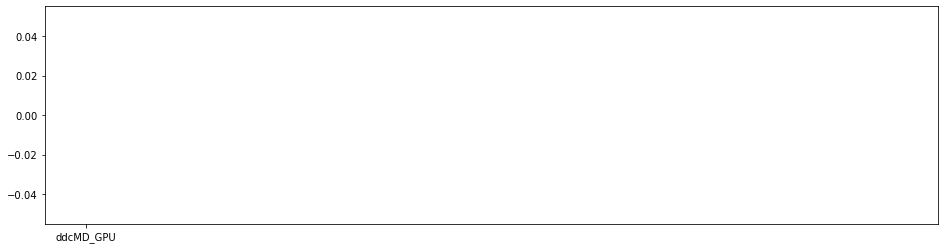

nan


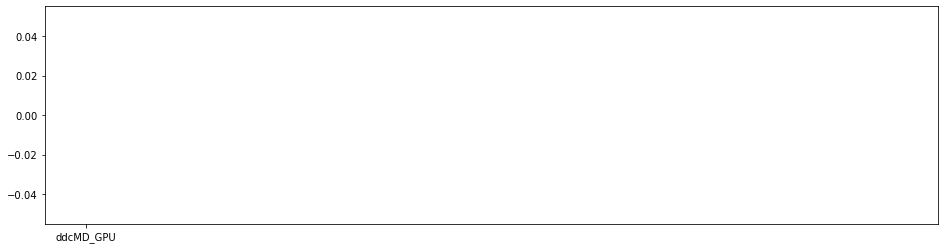

nan


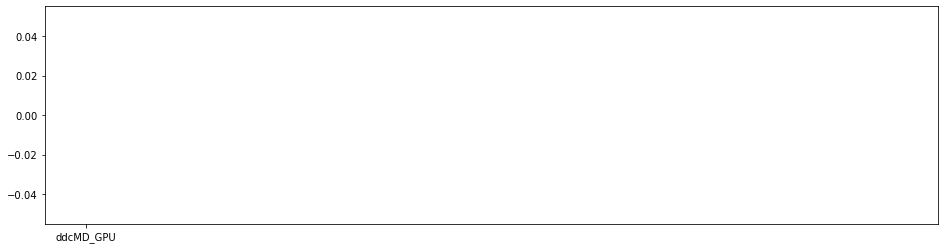

1255.7751901002048


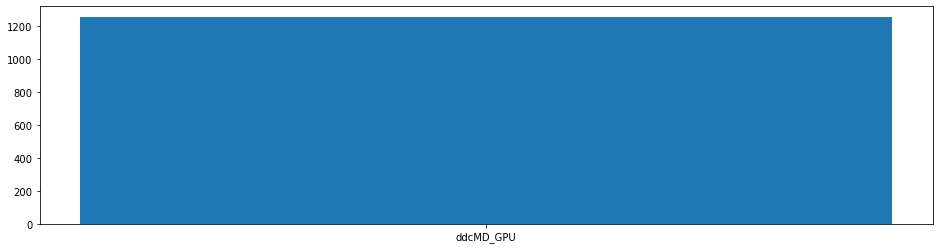

4682.21296219806


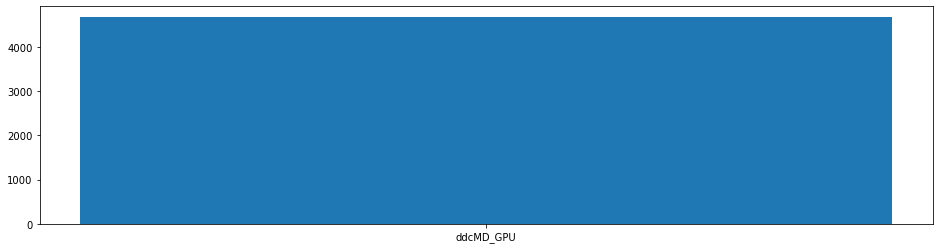

No handles with labels found to put in legend.


In [78]:
app_str = io_ddf_read_write['app'].unique()
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
request_size = [[]]*len(size_ranges)
for i, val in enumerate(size_ranges):
    request_size[i] = [0]*len(app_str)
    for j,app in enumerate(app_str):
        
        file_df_temp = io_ddf_read_write[io_ddf_read_write['app'] == app]
        max_range = len(size_ranges)
        if i < max_range - 1:
            request_size[i][j] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['bandwidth'].mean()
        else:
            request_size[i][j] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['bandwidth'].mean()
#fig, ax = plt.subplots(figsize=(16,4))
#width = 0.35
#plt.figure()
for i, val in enumerate(size_ranges):
    plt.figure(figsize=(16,4))
    print(np.sum(request_size[i]))
    rects1 = plt.bar(app_str, request_size[i], 0.35, label=str(i))
    plt.show()
ax.legend()

fig.tight_layout()

plt.show()

**Larger Request sizes have larger bandwidth. However as 4KB write dominates the application I/O we see small bandwidth overall**

### Overlapping of Compute and I/O

In [79]:
io_ddf.groupby('proc')['thread_id'].nunique().describe().compute()

count    109.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: thread_id, dtype: float64

#### No additional threads means I/O is synchronous to compute. I.e. all I/O is unoverlapped.

### Timeline
The timeline analysis shows how each rank performs I/O over the runtime of the applications

In [80]:
time_step=100 # in seconds

#### Request Size Timeline

[0.0, 0.0, 0.0, 0.0, 0.02531222254037857, 0.009144646115601063, 0.006096431985497475, 0.006096431985497475, 0.009144647978246212, 0.006096431985497475, 0.006096431985497475, 0.009144647978246212, 0.05922538321465254, 0.006093076430261135, 0.006093078292906284, 0.006093079224228859, 0.009139618836343288, 0.006093079224228859, 0.006093079224228859, 0.009139618836343288, 0.006093079224228859, 0.05928361788392067, 0.0061135059222579, 0.009170262143015862, 0.006113508716225624, 0.006113508716225624, 0.009170263074338436, 0.006113508716225624, 0.006113508716225624, 0.006113508716225624, 0.059320478700101376, 0.00913961511105299, 0.006093079224228859, 0.006093079224228859, 0.009139618836343288, 0.006093079224228859, 0.009139618836343288, 0.006093079224228859, 0.006093079224228859, 0.05916872713714838, 0.00912459660321474, 0.006083065643906593, 0.006083065643906593, 0.00912459846585989, 0.006083065643906593, 0.006083065643906593, 0.00912459846585989, 0.05931511148810387, 0.006136572919785976, 

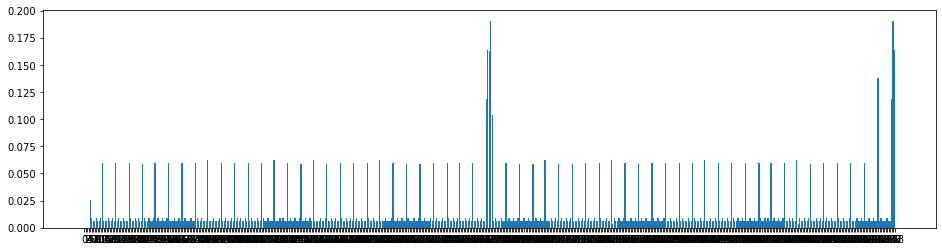

In [81]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
values_str = []
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

[0.0, 0.0, 0.0, 0.0, 0.022264008410274982, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022251645103096962, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022326978854835033, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022251645103096962, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022214720025658607, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022412038408219814, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022343463264405727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022369014099240303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022243402898311615, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02234115544706583, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022355991415679455, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022328132763504982, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022392751649022102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022347419522702694, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02245704084634781, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02221521455794573, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02229236

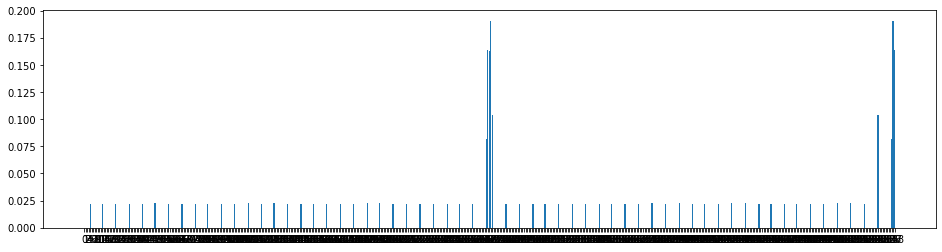

In [82]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
values_str = []
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & fread_condition
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

[0.0, 0.0, 0.0, 0.0, 0.003048214130103588, 0.009144646115601063, 0.006096431985497475, 0.006096431985497475, 0.009144647978246212, 0.006096431985497475, 0.006096431985497475, 0.009144647978246212, 0.036973738111555576, 0.006093076430261135, 0.006093078292906284, 0.006093079224228859, 0.009139618836343288, 0.006093079224228859, 0.006093079224228859, 0.009139618836343288, 0.006093079224228859, 0.036956639029085636, 0.0061135059222579, 0.009170262143015862, 0.006113508716225624, 0.006113508716225624, 0.009170263074338436, 0.006113508716225624, 0.006113508716225624, 0.006113508716225624, 0.037068833597004414, 0.00913961511105299, 0.006093079224228859, 0.006093079224228859, 0.009139618836343288, 0.006093079224228859, 0.009139618836343288, 0.006093079224228859, 0.006093079224228859, 0.03695400711148977, 0.00912459660321474, 0.006083065643906593, 0.006083065643906593, 0.00912459846585989, 0.006083065643906593, 0.006083065643906593, 0.00912459846585989, 0.03690307307988405, 0.00613657291978597

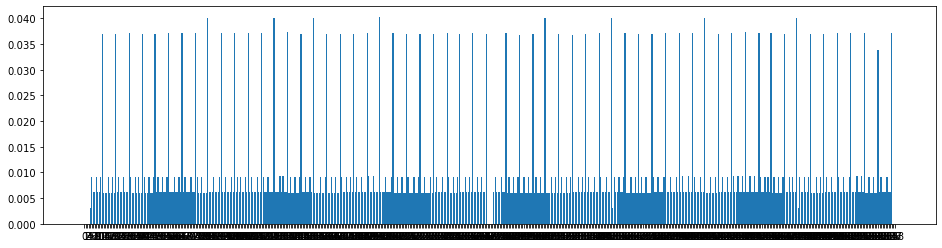

In [83]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
values_str = []
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & fwrite_condition
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

**Most of the I/O (20GB) is performed in first 40 seconds and rest 1GB happens in the rest of the time**

### Time Timeline

[0.0, 0.0, 0.0, 0.0, 0.0050354004, 0.00289917, 0.001953125, 0.001953125, 0.0028686523, 0.001953125, 0.001953125, 0.0029907227, 0.015014648, 0.001953125, 0.001953125, 0.001953125, 0.0028076172, 0.0017089844, 0.0017089844, 0.0028076172, 0.0017089844, 0.014892578, 0.001953125, 0.0029296875, 0.001953125, 0.001953125, 0.0029296875, 0.001953125, 0.001953125, 0.001953125, 0.014892578, 0.0029296875, 0.001953125, 0.001953125, 0.0026855469, 0.0017089844, 0.0026855469, 0.001953125, 0.0017089844, 0.015136719, 0.0029296875, 0.001953125, 0.001953125, 0.0029296875, 0.001953125, 0.001953125, 0.0029296875, 0.015625, 0.001953125, 0.0029296875, 0.001953125, 0.001953125, 0.0029296875, 0.001953125, 0.001953125, 0.0029296875, 0.0146484375, 0.001953125, 0.001953125, 0.001953125, 0.0029296875, 0.001953125, 0.001953125, 0.0029296875, 0.001953125, 0.015625, 0.001953125, 0.0024414062, 0.001953125, 0.001953125, 0.0014648438, 0.0024414062, 0.001953125, 0.001953125, 0.015625, 0.0029296875, 0.001953125, 0.001953125,

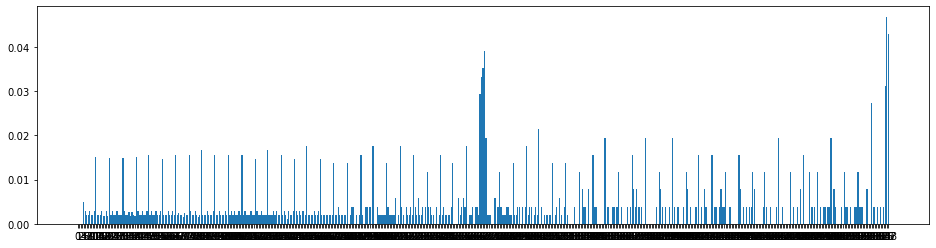

In [84]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['duration'].sum()
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

#### Bandwidth Timeline

[nan, nan, nan, nan, 4.276827841094046, 3.1549356829735538, 3.121373176574707, 3.121373176574707, 3.1907370249430342, 3.121373176574707, 3.121373176574707, 3.060169780955595, 3.7484652834745193, 3.119655132293701, 3.1196560859680176, 3.119656562805176, 3.26821163722447, 3.565321786063058, 3.565321786063058, 3.26821163722447, 3.565321786063058, 3.772427731869268, 3.130115032196045, 3.1301161448160806, 3.1301164627075195, 3.1301164627075195, 3.1301164627075195, 3.1301164627075195, 3.1301164627075195, 3.1301164627075195, 3.9310558016499946, 3.1196552912394204, 3.119656562805176, 3.119656562805176, 3.466285069783529, 3.639599323272705, 3.466285069783529, 3.119656562805176, 3.639599323272705, 3.9070775804955975, 3.1145289738972983, 3.114529609680176, 3.114529609680176, 3.114529609680176, 3.114529609680176, 3.114529609680176, 3.114529609680176, 3.6896319140016645, 3.14192533493042, 3.1419264475504556, 3.1419267654418945, 3.1419267654418945, 3.1419267654418945, 3.1419267654418945, 3.141926765

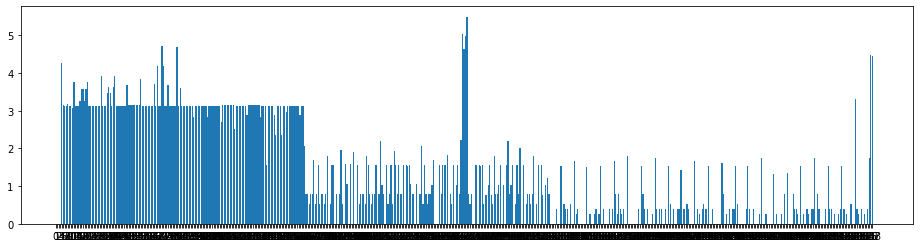

In [85]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

[nan, nan, nan, nan, 5.526871421120384, nan, nan, nan, nan, nan, nan, nan, 5.696421146392822, nan, nan, nan, nan, nan, nan, nan, nan, 5.3794885523179, nan, nan, nan, nan, nan, nan, nan, nan, 5.361337549546185, nan, nan, nan, nan, nan, nan, nan, nan, 5.352440777946921, nan, nan, nan, nan, nan, nan, nan, 5.099983851114909, nan, nan, nan, nan, nan, nan, nan, nan, 5.719926595687866, nan, nan, nan, nan, nan, nan, nan, nan, 5.090193430582683, nan, nan, nan, nan, nan, nan, nan, nan, 5.0616099039713545, nan, nan, nan, nan, nan, nan, nan, 5.083854039510091, nan, nan, nan, nan, nan, nan, nan, nan, 5.72313380241394, nan, nan, nan, nan, nan, nan, nan, nan, 5.716001987457275, nan, nan, nan, nan, nan, nan, nan, nan, 4.586035537719726, nan, nan, nan, nan, nan, nan, nan, nan, 5.72093939781189, nan, nan, nan, nan, nan, nan, nan, 5.749002456665039, nan, nan, nan, nan, nan, nan, nan, nan, 5.6870949268341064, nan, nan, nan, nan, nan, nan, nan, nan, 5.7068445682525635, nan, nan, nan, nan, nan, nan, nan, 5.

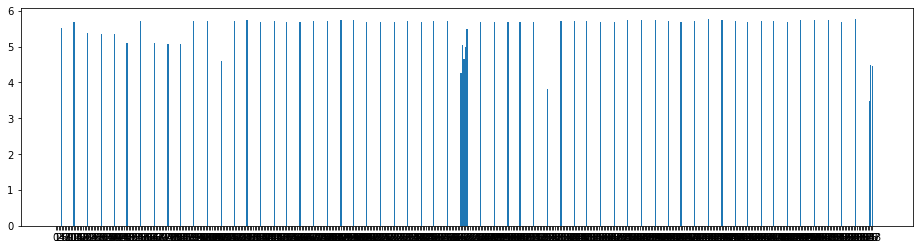

In [86]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & fread_condition
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

[nan, nan, nan, nan, 3.0267842610677085, 3.1549356829735538, 3.121373176574707, 3.121373176574707, 3.1907370249430342, 3.121373176574707, 3.121373176574707, 3.060169780955595, 3.3588741108908584, 3.119655132293701, 3.1196560859680176, 3.119656562805176, 3.26821163722447, 3.565321786063058, 3.565321786063058, 3.26821163722447, 3.565321786063058, 3.451015567779541, 3.130115032196045, 3.1301161448160806, 3.1301164627075195, 3.1301164627075195, 3.1301164627075195, 3.1301164627075195, 3.1301164627075195, 3.1301164627075195, 3.6449994520707563, 3.1196552912394204, 3.119656562805176, 3.119656562805176, 3.466285069783529, 3.639599323272705, 3.466285069783529, 3.119656562805176, 3.639599323272705, 3.6180049410053328, 3.1145289738972983, 3.114529609680176, 3.114529609680176, 3.114529609680176, 3.114529609680176, 3.114529609680176, 3.114529609680176, 3.4075615265790153, 3.14192533493042, 3.1419264475504556, 3.1419267654418945, 3.1419267654418945, 3.1419267654418945, 3.1419267654418945, 3.14192676

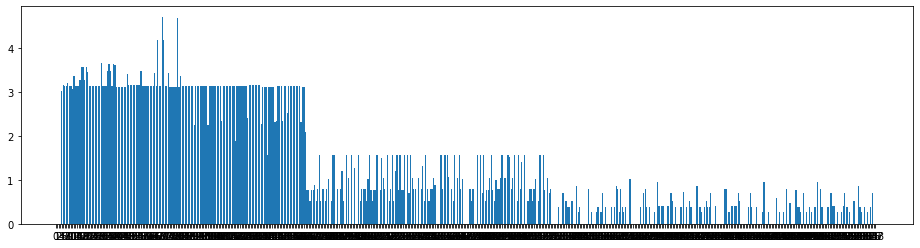

In [87]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & fwrite_condition
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

**This supports our previous observation as the bandwidth is the measure of I/O performance of the application.**

#### Bandwidth Timeline Per Rank

app ddcMD_GPU


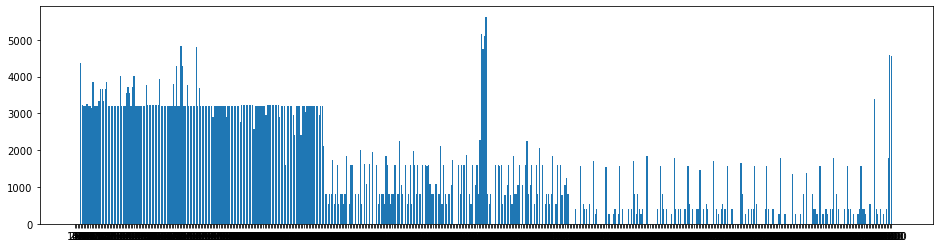

In [88]:
import math

selected_app = io_ddf_read_write['app'].unique()

plt.figure(figsize=(16,4))
for app in selected_app:
    io_df_rank = io_ddf_read_write[io_ddf_read_write['app'] == app]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    value_str = []
    prev = 0
    for i in values_int:
        value_str.append(str(values[i]))
        contains = (io_df_rank['tstart'] >=prev) & (io_df_rank['tend'] <values[i])
        timeline_ts[i] = io_df_rank[contains]['bandwidth'].mean()
        prev = values[i]
    print("app {}".format(app))
    plt.bar(value_str, timeline_ts)
    plt.show()

**Most I/O happens in the first 40 sec and most bandwidth is achieved from PFS**

#### Request Size Timeline per Rank

app ddcMD_GPU


<Figure size 1152x288 with 0 Axes>

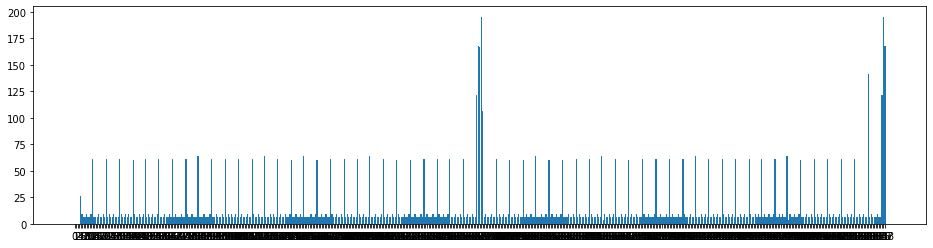

In [89]:
import math
selected_app = io_ddf_read_write['app'].unique()

plt.figure(figsize=(16,4))
for app in selected_app:
    io_df_rank = io_ddf_read_write[io_ddf_read_write['app'] == app]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    value_str = []
    prev = 0
    for i in values_int:
        value_str.append(str(i))
        contains = (io_df_rank['tstart'] >=prev) & (io_df_rank['tend'] <values[i])
        timeline_ts[i] = io_df_rank[contains]['size'].sum()/1024.0/1024.0
        prev = values[i]
    print("app {}".format(app))
    plt.figure(figsize=(16,4))
    plt.bar(value_str, timeline_ts)
    plt.show()

**Only rank 0 does I/O throughout the time. Rest perform read in first 40 seconds and perform computations.** 

## Find file which are independent or shared
- Make all thread id start from 0 and unique across ranks
- Group by filename nunique thread_id
- Find all filename with nunique > 1

In [90]:
thread_index_series = io_ddf.groupby(['proc', 'thread_id'])['thread_id'].nunique().cumsum().compute()

In [91]:
proc_index_series = io_ddf.groupby(['hostname','proc'])['thread_id'].nunique().cumsum().compute()

In [92]:
#io_ddf['thread_index'] = 0
#for index,item in thread_index_series.iteritems():
#    condition = (io_ddf['proc'] == index[0]) & (io_ddf['thread_id'] == index[1])
#    io_ddf['thread_index'] = io_ddf['thread_index'].mask(condition , item - 1)

In [93]:
num_procs = proc_index_series.count()
threads = thread_index_series.count()
print("We have {} threads across {} process".format(threads, num_procs))

We have 109 threads across 109 process


In [94]:
filename_series = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')].groupby(['filename'])['proc'].nunique().compute()

In [95]:
independent_files = filename_series[filename_series == 1]
print("{} files that are accessed by application by only one rank".format(len(independent_files)))

0 files that are accessed by application by only one rank


In [96]:
shared_files = filename_series[filename_series > 1]
print("{} files that are accessed by application by more than one rank".format(len(shared_files)))

0 files that are accessed by application by more than one rank


This application doesnt share files. That is it follows a File per process pattern.

### Data Flow
We plot how different ranks in the job are accessing data.

In [97]:
io_ddf_read_write['file_type'] = io_ddf_read_write['filename'] 
io_ddf_read_write['file_type'] = io_ddf_read_write['file_type'].apply(lambda x: x.split('/')[-1])
io_ddf_read_write['file_type'] = io_ddf_read_write['file_type'].apply(lambda x: x.split('_')[0])
io_ddf_read_write['file_type'] = io_ddf_read_write['file_type'].apply(lambda x: x.split('.')[0] + "*") # keep first part of dot
io_ddf_read_write['file_type'] = io_ddf_read_write['file_type'].apply(lambda x: x.split('-')[1] if '-' in x else x)
                              

In [98]:
io_ddf_read_write

,index,proc,rank,thread_id,cat,tstart,tend,func_id,level,hostname,...,args_7,args_8,args_9,args_10,duration,filename,size,count,bandwidth,file_type
25731,25732,68209,0,-135550816,0,51732.671875,51732.675781,fread,0,lassen123,...,,,,,0.003906,/tmp/mummi/cg/mu12-1ras0raf-instance6_00000000...,23782959,23782959,5806.386475,atoms#000000*
259234,259235,68209,0,-135550816,0,51790.296875,51790.296875,fwrite,0,lassen123,...,,,,,0.000000,/tmp/mummi/cg/mu12-1ras0raf-instance6_00000000...,3256339,3256339,0.000000,subset#000000*
394317,394318,68209,0,-135550816,0,51833.453125,51833.457031,fwrite,0,lassen123,...,,,,,0.003906,/tmp/mummi/cg/mu12-1ras0raf-instance6_00000000...,3256340,3256340,795.004883,subset#000000*
529400,529401,68209,0,-135550816,0,51876.574219,51876.574219,fwrite,0,lassen123,...,,,,,0.000000,/tmp/mummi/cg/mu12-1ras0raf-instance6_00000000...,3256340,3256340,0.000000,subset#000000*
664483,664484,68209,0,-135550816,0,51919.804688,51919.808594,fwrite,0,lassen123,...,,,,,0.003906,/tmp/mummi/cg/mu12-1ras0raf-instance6_00000000...,3256341,3256341,795.005127,subset#000000*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825769,2825770,87148,0,-135550816,0,1183.757202,1183.765381,fwrite,0,lassen647,...,,,,,0.008179,/tmp/mummi/cg/mu12-1ras0raf-instance10_0000000...,29204532,29204532,3405.379198,atoms#000000*
2830834,2830835,87148,0,-135550816,0,1184.130859,1184.131836,fwrite,0,lassen647,...,,,,,0.000977,/tmp/mummi/cg/mu12-1ras0raf-instance10_0000000...,3272998,3272998,3196.287109,subset#000000*
2830874,2830875,87148,0,-135550816,0,1184.158081,1184.158569,fwrite,0,lassen647,...,,,,,0.000488,/tmp/mummi/cg/mu12-1ras0raf-instance10_0000000...,1974861,1974861,3857.150391,profile#000000*
2830912,2830913,87148,0,-135550816,0,1184.184937,1184.185547,fwrite,0,lassen647,...,,,,,0.000610,/tmp/mummi/cg/mu12-1ras0raf-instance10_0000000...,1974861,1974861,3085.720313,profile#000000*


In [99]:
#call_series = io_ddf_read_write.groupby(['hostname','app','proc','func_id','file_type']).agg({'size': ['sum','count']})
call_series = io_ddf_read_write.groupby(['app','func_id','file_type']).agg({'size': ['sum','count'], 'proc':['nunique'], 'tstart':['min'], 'tend':['max'], 'duration':['sum']}).sort_values(by=[('tstart','min')])

In [100]:
call_series

size          proc       tstart  \
                                            sum count nunique          min   
app       func_id file_type                                                  
ddcMD_GPU fread   atoms#000000*    2.839776e+09   108     108   304.176544   
          fwrite  subset#000000*   3.935348e+09  1200      60   361.968140   
                  atoms#000000*    1.755760e+09    60      60  1183.757202   
                  profile#000000*  2.371333e+08   120      60  1184.158081   

                                           tend  duration  
                                            max       sum  
app       func_id file_type                                
ddcMD_GPU fread   atoms#000000*    53859.421875  0.535034  
          fwrite  subset#000000*   53554.261719  1.126343  
                  atoms#000000*    53553.898438  0.484497  
                  profile#000000*  53554.316406  0.054810

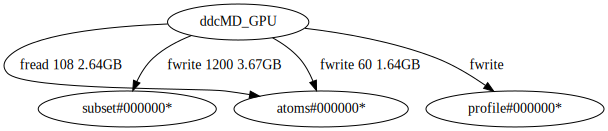

In [127]:
import graphviz
dot = graphviz.Digraph()
dot.attr(ordering="out")
for index, value in call_series.iterrows():
    #for v1, v2 in call_series.iteritems():
    #print( value)
    #value = v2.index[0]
    #index = v2.index[0]
    node_str = index[0] #+ " " + str(value[2])
    file_node_str = index[2]
    func_node_str = index[1]
    dot.node(node_str)
    dot.node(file_node_str)
    #dot.node(func_node_str)
    if value[0] > 1024.0 * 1024.0* 1024.0:
        dot.edge(node_str, file_node_str, label=func_node_str + " "+ "{}".format(int(value[1])) + " " + "{:0.2f}GB".format(value[0]/1024.0/1024.0/1024.0))
    else:
        dot.edge(node_str, file_node_str, label=func_node_str)
#     if "read" in func_node_str:
#         dot.edge(file_node_str, func_node_str, label=str(value[0]/1024.0) + "KB")
#     else:
#         dot.edge(func_node_str,file_node_str, label=str(value[0]/1024.0)+ "KB")

a = graphviz.Digraph('app')
a.attr(rank='same')
a.attr(ordering="out")
for index, value in call_series.iterrows():
    node_str = index[0]
    a.node(node_str)

# o = graphviz.Digraph('func')
# o.attr(rank='same')
# for index, value in call_series.iterrows():
#     node_str = index[1]
#     o.node(node_str)
    
f = graphviz.Digraph('file')
f.attr(rank='same')
for index, value in call_series.iterrows():
    node_str = index[2]
    f.node(node_str)
    
dot.subgraph(a)
# dot.subgraph(o)
dot.subgraph(f)
dot

In [125]:
import graphviz
dot = graphviz.Digraph()
selected_indices = range(1)
if len(shared_files) > len(selected_indices):
    for selected_index in selected_indices:
        selected_shared_file = shared_files.index[selected_index]
        io_access_rank = io_ddf[io_ddf['filename'] == selected_shared_file].groupby(['app','func_id'])['func_id'].count().compute()
        dot.node(selected_shared_file)
        for index,item in io_access_rank.iteritems():
            rank = index[0]
            func_id = index[1]
            count = item
            dot.node(str(rank))
            dot.node(func_id)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(selected_shared_file, func_id, label=str(count))
            else:
                dot.edge(func_id,selected_shared_file, label=str(count))

In [126]:
dot

In [103]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    if len(independent_files) > selected_index:
        selected_file = independent_files.index[selected_index]
        io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['app','func_id'])['func_id'].count().compute()
        dot.node(selected_file)
        for index,item in io_access_rank.iteritems():
            rank = index[0]
            func_id = index[1]
            count = item
            dot.node(str(rank))
            dot.node(func_id)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(selected_file, func_id, label=str(count))
            else:
                dot.edge(func_id,selected_file, label=str(count))

In [104]:
dot

## Calculate Access Pattern
- Calculate segment_index
  - select file_ptr based on open flag
  - update file_ptr based on operation
  - do a cum_sum on file_ptr to calculate final file_ptr
  - assign segment_index based on granularity (median transfer size)
- isolate segment index into
  - sequential flag if segment index is increasing
  - consequitive flag if segment index is increasing and one after the other

#### Persist the current version of I/O dataframe.

In [105]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Select files which have no seeks and those which have

In [106]:
files_with_seek = io_ddf[io_ddf['func_id'].str.contains('seek') & io_ddf['filename'].str.contains('/p/gpfs')]['filename'].unique().compute()
print("{} files have seek operations".format(len(files_with_seek)))

0 files have seek operations


In [107]:
files_with_seek

Series([], Name: filename, dtype: object)

In [108]:
all_filenames

Series([], Name: filename, dtype: object)

In [109]:
files_without_seek = set(all_filenames) - set(files_with_seek)
print("{} files have no seek operations and hence are sequential".format(len(files_without_seek)))

0 files have no seek operations and hence are sequential


### Per File Analysis
- Total I/O amount
- Total I/O time (average per process)
- Average Bandwidth
- I/O Request Distribution

In [110]:
per_file_size = io_ddf_read_write.groupby(['filename'])['size'].sum()
per_file_size = per_file_size / 1024.0/1024.0
per_file_size = per_file_size.sort_values(ascending=False)
per_file_size.head(5)

filename
/tmp/mummi/cg/mu12-1ras0raf-instance4_000000000001_20220124-140115/snapshot.000000500000/atoms#000000    56.174709
/tmp/mummi/cg/mu12-1ras0raf-instance4_000000000010_20220124-132205/snapshot.000000500000/atoms#000000    56.135983
/tmp/mummi/cg/mu12-1ras0raf-instance2_000000000005_20220124-135342/snapshot.000000500000/atoms#000000    56.112911
/tmp/mummi/cg/mu12-1ras0raf-instance9_000000000004_20220124-135503/snapshot.000000500000/atoms#000000    56.094784
/tmp/mummi/cg/mu12-1ras0raf-instance5_000000000002_20220124-132221/snapshot.000000500000/atoms#000000    56.013622
Name: size, dtype: float64

In [111]:
per_file_time = io_ddf_read_write.groupby(['filename'])['duration'].sum().sort_values(ascending=False)
per_file_time.head(5)

filename
/tmp/mummi/cg/mu12-1ras0raf-instance1_000000000001_20220124-135707/snapshot.000000500000/atoms#000000     0.019531
/tmp/mummi/cg/mu12-1ras0raf-instance9_000000000008_20220124-135536/snapshot.000000500000/atoms#000000     0.019531
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000010_20220124-131655/snapshot.000000500000/atoms#000000    0.015991
/tmp/mummi/cg/mu12-1ras0raf-instance5_000000000003_20220124-135758/snapshot.000000500000/atoms#000000     0.015625
/tmp/mummi/cg/mu12-1ras0raf-instance8_000000000004_20220124-135349/snapshot.000000500000/atoms#000000     0.015625
Name: duration, dtype: float32

In [112]:
per_file_bw = io_ddf_read_write.groupby(['filename'])['bandwidth'].sum().sort_values(ascending=True)
per_file_bw.head(5)

filename
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000001_20220124-135055/snapshot.000000025000/subset#000000    0.0
/tmp/mummi/cg/mu12-1ras0raf-instance5_000000000002_20220124-132221/snapshot.000000500000/subset#000000     0.0
/tmp/mummi/cg/mu12-1ras0raf-instance5_000000000003_20220124-135758/snapshot.000000025000/subset#000000     0.0
/tmp/mummi/cg/mu12-1ras0raf-instance5_000000000003_20220124-135758/snapshot.000000050000/subset#000000     0.0
/tmp/mummi/cg/mu12-1ras0raf-instance5_000000000003_20220124-135758/snapshot.000000075000/subset#000000     0.0
Name: bandwidth, dtype: float64

In [113]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    selected_file = per_file_size.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['app','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        if "read" in func_id or "write" in func_id:
            dot.node(str(rank))
            dot.node(func_id)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(selected_file, func_id, label=str(count))
            elif "write" in func_id:
                dot.edge(func_id,selected_file, label=str(count))

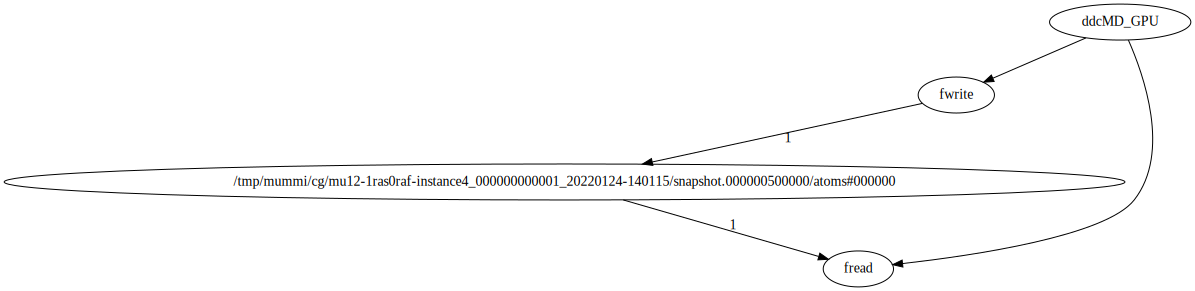

In [114]:
dot

In [115]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    selected_file = per_file_time.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['app','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        dot.node(str(rank))
        dot.node(func_id)
        dot.edge(str(rank),func_id)
        if "read" in func_id:
            dot.edge(selected_file, func_id, label=str(count))
        else:
            dot.edge(func_id,selected_file, label=str(count))

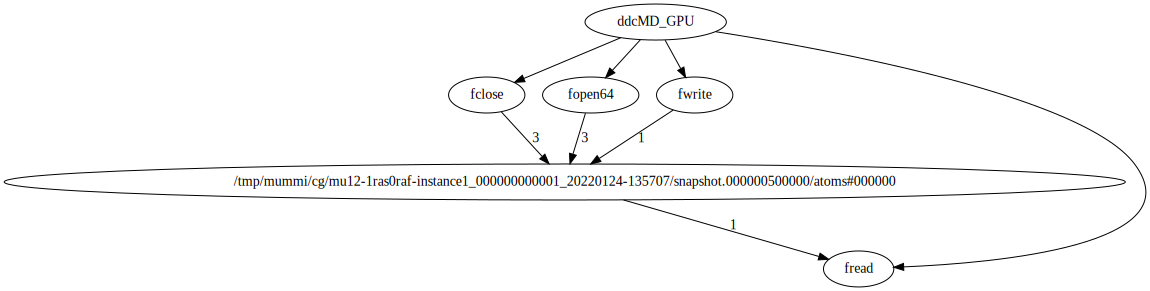

In [116]:
dot

In [117]:
import graphviz
dot = graphviz.Digraph()
selected_indices = range(5)
for selected_index in selected_indices:
    selected_file = per_file_bw.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['app','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        dot.node(str(rank))
        dot.node(func_id)
        dot.edge(str(rank),func_id)
        if "read" in func_id:
            dot.edge(selected_file, func_id, label=str(count))
        else:
            dot.edge(func_id,selected_file, label=str(count))

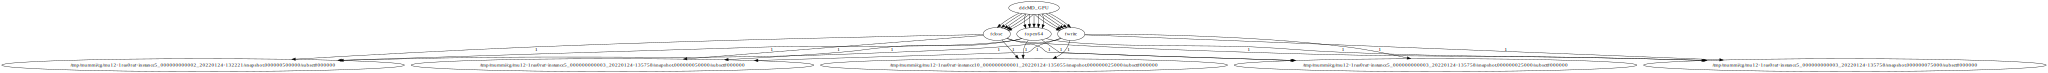

In [118]:
dot

In [119]:
write_files = io_ddf_read_write[io_ddf_read_write['func_id'].str.contains('write')]['filename'].unique()
read_files = io_ddf_read_write[io_ddf_read_write['func_id'].str.contains('read')]['filename'].unique()
read_only_files = set(all_filenames) - set(write_files)
write_only_files = set(all_filenames) - set(read_files)
print("{} files are written into.\n{} file are read from.\n{} files are write-only.\n{} file are read-only."
      .format(len(write_files), len(read_files), len(write_only_files), len(read_only_files)))

1320 files are written into.
108 file are read from.
0 files are write-only.
0 file are read-only.


In [120]:
print(read_only_files)

set()


In [124]:
io_per_file = io_ddf_read_write[io_ddf_read_write['filename'].isin(read_files)].groupby(['filename'])['size'].sum()
io_per_file = io_per_file / 1024.0/1024.0
print(io_per_file)

filename
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000001_20220124-135055/snapshot.000000500000/atoms#000000    55.726467
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000001_20220124-135055/snapshot.mem/atoms#000000             22.820120
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000002_20220124-132014/snapshot.000000500000/atoms#000000    55.551373
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000002_20220124-132014/snapshot.mem/atoms#000000             22.748380
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000006_20220124-132341/snapshot.000000500000/atoms#000000    55.563320
                                                                                                            ...    
/tmp/mummi/cg/mu12-1ras0raf-instance9_000000000007_20220124-135027/snapshot.mem/atoms#000000              22.783153
/tmp/mummi/cg/mu12-1ras0raf-instance9_000000000008_20220124-135536/snapshot.000000500000/atoms#000000     55.606991
/tmp/mummi/cg/mu12-1ras0raf-instance9_000000000008_20220124-135

In [122]:
io_per_file = io_ddf_read_write[io_ddf_read_write['filename'].isin(write_files) & io_ddf_read_write['func_id'].str.contains("write")].groupby(['filename'])['size'].sum()
io_per_file = io_per_file / 1024.0/1024.0
print(io_per_file.head(20))

filename
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000001_20220124-135055/snapshot.000000025000/subset#000000     3.124324
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000001_20220124-135055/snapshot.000000050000/subset#000000     3.124325
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000001_20220124-135055/snapshot.000000075000/subset#000000     3.124325
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000001_20220124-135055/snapshot.000000100000/subset#000000     3.124326
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000001_20220124-135055/snapshot.000000125000/subset#000000     3.124326
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000001_20220124-135055/snapshot.000000150000/subset#000000     3.124326
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000001_20220124-135055/snapshot.000000175000/subset#000000     3.124326
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000001_20220124-135055/snapshot.000000200000/subset#000000     3.124326
/tmp/mummi/cg/mu12-1ras0raf-instance10_000000000001_202

In [123]:
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv","fread"])
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev","fwrite"])
data_ops = ['read', 'write']
total_time_io_data = io_ddf[ read_condition | write_condition ].groupby('rank')['duration'].sum().max().compute()
total_time_io_metadata = io_ddf[~(read_condition | write_condition)].groupby('rank')['duration'].sum().max().compute()
print("Time spent on data: {} sec, metadata: {} sec".format(total_time_io_data, total_time_io_metadata))

Time spent on data: 2.20068359375 sec, metadata: 0.3256032466888428 sec
